In [1]:
import os
import numpy as np
import glob
import sys
import pickle
from tqdm import notebook

from music21 import corpus, converter, instrument, note, chord
from utils import *
from generate import *
from model import create_network

import tensorflow
from tensorflow import keras

from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
with open('Pickle\\beethoven_mozart_n_d_v', 'rb') as f:
    ndv = pickle.load(f)
with open('Pickle\\beethoven_mozart_distincts', 'rb') as f:
    distincts = pickle.load(f)
with open('Pickle\\beethoven_mozart_lookups', 'rb') as f:
    lookups = pickle.load(f)

In [3]:
notes = ndv[0]
durations = ndv[1]
velocities = ndv[2]

In [4]:
network_input, network_output = prepare_sequences(notes, durations, velocities, lookups, distincts, 100)

In [5]:
network_input[0].shape

(194341, 100)

In [6]:
notes, durations, velocities = ndv

note_to_int, int_to_note, duration_to_int, int_to_duration, velocity_to_int, int_to_velocity = lookups

In [7]:
n_notes = distincts[1]
n_durations = distincts[3]
n_velocities = distincts[5]
embed_size = 100
rnn_units = 512

In [8]:
n_durations

483

In [9]:
model = create_network(n_notes, n_durations, n_velocities, embed_size, rnn_units)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    41700       input_1[0][0]                    
______________________________________________________________________________________________

In [10]:
weights_folder = 'Weights'
logs_base_dir = "Logs"
history_folder = "History"

In [11]:
callbacks_list = make_callbacks_list(weights_folder, logs_base_dir, history_folder)

In [13]:
%reload_ext tensorboard
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {makeWindowsCmdPath(logs_base_dir)} --reload_multifile True

Reusing TensorBoard on port 6006 (pid 13660), started 0:00:12 ago. (Use '!kill 13660' to kill it.)

In [18]:
model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [15]:
history = model.fit(network_input, network_output,
                    epochs=100, batch_size=128,
                    callbacks=callbacks_list,
                    shuffle=True
                   )

Train on 194341 samples
Epoch 1/100
194341/194341 [==============================] - 1085s 6ms/sample - loss: 6.4729 - pitch_loss: 3.8890 - duration_loss: 1.2233 - velocity_loss: 1.3603 - pitch_accuracy: 0.1153 - duration_accuracy: 0.6776 - velocity_accuracy: 0.5647
Epoch 2/100
194341/194341 [==============================] - 1091s 6ms/sample - loss: 5.3691 - pitch_loss: 3.2577 - duration_loss: 0.9563 - velocity_loss: 1.1550 - pitch_accuracy: 0.1860 - duration_accuracy: 0.7112 - velocity_accuracy: 0.6123
Epoch 3/100
194341/194341 [==============================] - 1072s 6ms/sample - loss: 4.8634 - pitch_loss: 2.9294 - duration_loss: 0.8649 - velocity_loss: 1.0691 - pitch_accuracy: 0.2542 - duration_accuracy: 0.7371 - velocity_accuracy: 0.6396
Epoch 4/100
194341/194341 [==============================] - 1056s 5ms/sample - loss: 4.4232 - pitch_loss: 2.6536 - duration_loss: 0.7896 - velocity_loss: 0.9800 - pitch_accuracy: 0.3137 - duration_accuracy: 0.7541 - velocity_accuracy: 0.6678
Epoc

194341/194341 [==============================] - 1055s 5ms/sample - loss: 0.7371 - pitch_loss: 0.3829 - duration_loss: 0.1496 - velocity_loss: 0.2047 - pitch_accuracy: 0.8771 - duration_accuracy: 0.9468 - velocity_accuracy: 0.9271
Epoch 35/100
194341/194341 [==============================] - 1056s 5ms/sample - loss: 0.7000 - pitch_loss: 0.3625 - duration_loss: 0.1430 - velocity_loss: 0.1945 - pitch_accuracy: 0.8838 - duration_accuracy: 0.9497 - velocity_accuracy: 0.9320
Epoch 36/100
194341/194341 [==============================] - 1054s 5ms/sample - loss: 0.7205 - pitch_loss: 0.3787 - duration_loss: 0.1447 - velocity_loss: 0.1972 - pitch_accuracy: 0.8794 - duration_accuracy: 0.9485 - velocity_accuracy: 0.9301
Epoch 37/100
194341/194341 [==============================] - 1055s 5ms/sample - loss: 0.6911 - pitch_loss: 0.3577 - duration_loss: 0.1419 - velocity_loss: 0.1917 - pitch_accuracy: 0.8851 - duration_accuracy: 0.9499 - velocity_accuracy: 0.9331
Epoch 38/100
194341/194341 [=========

KeyboardInterrupt: 

In [20]:
import pandas as pd
log_data = pd.read_csv(os.path.join(history_folder, 'model_history_log.csv'))

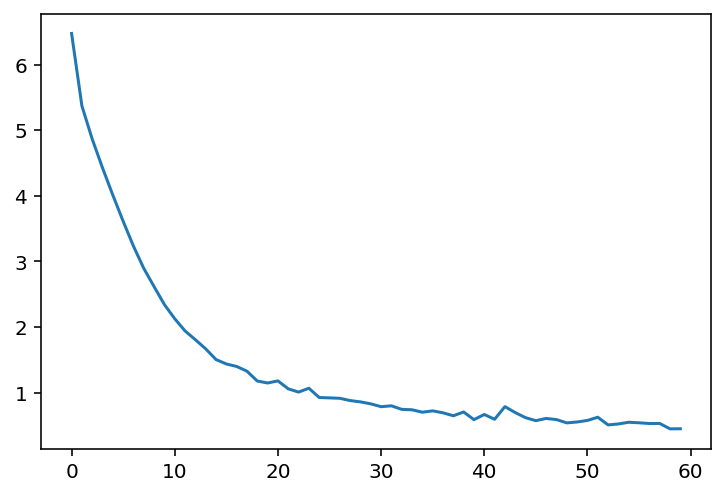

In [21]:
log_data['loss'].plot()

In [ ]:
input_note_seq, input_duration_seq, input_velocity_seq = build_sequence(64, notes, durations, velocities)

In [ ]:
whole_pattern, gen_pattern = generate_sequence(model, input_note_seq,
                                               input_duration_seq,
                                               input_velocity_seq,
                                               note_to_int,
                                               duration_to_int,
                                               velocity_to_int,
                                               256)

In [ ]:
midi_out_whole = create_midi(whole_pattern, int_to_note, int_to_duration, int_to_velocity)
midi_out_gen = create_midi(gen_pattern, int_to_note, int_to_duration, int_to_velocity)

In [ ]:
write_midi(midi_out_whole)

In [ ]:
write_midi(midi_out_gen)